In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import os
import time

import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer
import qiskit as qiskit
import qiskit.quantum_info as qi
from qiskit import QuantumCircuit, transpile, Aer, IBMQ

import ramsey_experiment

# Loading your IBM Quantum account(s)
IBMQ.save_account(os.environ.get('IBM_KEY'), overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')
import Ramsey_ExperimentV2
import random
import importlib
from tqdm import tqdm
ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

ibmqfactory.load_account:WARNING:2024-02-22 16:47:38,208: Credentials are already in use. The existing account in the session will be replaced.


In [46]:
import numpy as np
import math
n = 4
T = 0.5*np.pi
shots = 10000
measurements = 10
delay = np.linspace(0, T, measurements)
# delay= [1.5 3]
optimal_delay = [0.05, 1.4]
optimal_shots = [2000, 3000]

W = [random.gauss(0, 3) for _ in range(n)]
L = [random.gauss(3, 1) for _ in range(n)]
J = [random.gauss(0, 3) for _ in range(n - 1)]

# L = [3,3,3,3]
# J = [4,4,4]
# W = [4,4,4,4]

batch_x = []
batch_y = []

delay = [0.3, 0.5]
for t in tqdm(delay):
    exp_x = RamseyExperiment(n, t, 100000, J, W, L, basis="X")
    exp_y = RamseyExperiment(n, t, 100000, J, W, L, basis="Y")
    exp_x.create_full_circuit()
    exp_y.create_full_circuit()
    exp_x.add_decay_raw()
    exp_y.add_decay_raw()
    batch_x.append(exp_x)
    batch_y.append(exp_y)

batch_x = RamseyBatch(batch_x)
batch_y = RamseyBatch(batch_y)

#print(effective_hem(3,J,W))

100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


In [606]:
ramsey_experiment = importlib.reload(Ramsey_ExperimentV2)
RamseyExperiment = ramsey_experiment.RamseyExperiment
RamseyBatch = ramsey_experiment.RamseyBatch

In [47]:

guessed_decay,guessed_W,guessed_J = ramsey_experiment.full_complex_fit(batch_x, batch_y)

print("guessed decay: ", guessed_decay)
print("real decay: ", L)
print("guessed frequency: ", guessed_W)
print("real frequency: ", W)
print("guessed J: ", guessed_J)
print("real J: ", J)

guessed = np.concatenate([guessed_decay,guessed_W,guessed_J])
real_parameters = np.concatenate([L,W,J])
mse = np.mean((guessed - real_parameters)**2)
print("error: ", np.sqrt(mse))

guessed decay:  [3.68035355 4.31551703 1.72068487 3.39676274]
real decay:  [3.8624835013949923, 4.319662849407038, 1.6614517820461114, 3.4319784160490876]
guessed frequency:  [-0.67714368 -4.29176738  1.89244915 -6.13486567]
real frequency:  [1.1664987007597802, -2.5173343250283473, 1.7754528626265618, -6.126751938130779]
guessed J:  [2.14110861 3.39017952 0.34637996]
real J:  [-1.4917067747639106, 3.5182242627179963, 0.45771830738967995]
error:  1.342503101269371


In [50]:
import symbolic_evolution
importlib.reload(symbolic_evolution)
symbolic_exp = symbolic_evolution.get_expectation_values(n,W,J,L, neighbors=1)


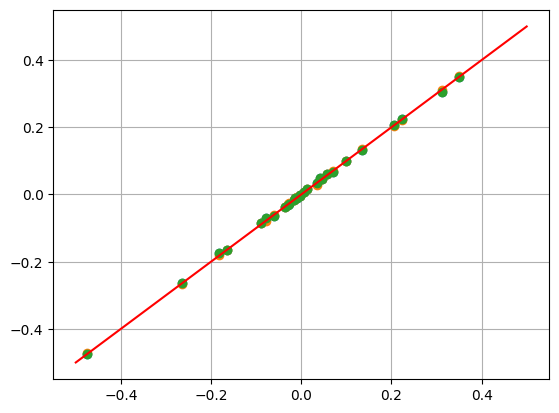

In [51]:
def model_func(times, A, W, J):
    x_models = []
    y_models = []

    x_correlations = []
    y_correlations = []

    A = A[::-1]
    W = W[::-1]
    J = J[::-1]


    X = []
    Y = []
    for t in times:
        for i in range(n):
            x_model = (np.cos(W[i] * t)) * np.exp(-A[i] * t)
            y_model = -(np.sin(W[i] * t)) * np.exp(-A[i] * t)
            norm = 1
            if i > 0:
                x_model += np.cos((W[i] + J[i - 1]) * t) * np.exp(-A[i] * t)
                y_model -= np.sin((W[i] + J[i - 1]) * t) * np.exp(-A[i] * t)
                norm += 1

            if i < n - 1:
                x_model += np.cos((W[i] + J[i]) * t) * np.exp(-A[i] * t)  # Updated to use J[i] instead of J[i + 1]
                y_model -= np.sin((W[i] + J[i]) * t) * np.exp(-A[i] * t)  # Same here, for consistency
                norm += 1

            if 0 < i < n - 1:
                x_model += np.cos((W[i] + J[i - 1] + J[i]) * t) * np.exp(-A[i] * t)
                y_model -= np.sin((W[i] + J[i - 1] + J[i]) * t) * np.exp(-A[i] * t)
                norm += 1
            x_models.append(x_model/norm)
            y_models.append(y_model/norm)

            X.append(x_model/norm)
            Y.append(y_model/norm)
        for i in range(n-1):
            x_correlation = 0
            norm = 0
            if i < len(J):
                x_correlation += (np.cos((W[i] + W[i + 1] + J[i]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                x_correlation += (np.cos((W[i] - W[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                norm += 2
                if i + 1 < len(J):
                    x_correlation += (np.cos((W[i] + W[i + 1] + J[i] + J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    x_correlation += (np.cos((W[i + 1] - W[i] + J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    norm += 2

            if i - 1 >= 0:
                x_correlation += (np.cos((W[i] - W[i + 1] + J[i - 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                x_correlation += (np.cos((W[i] + W[i + 1] + J[i] + J[i - 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                norm += 2
                if i + 1 < len(J):
                    x_correlation += (np.cos((W[i] - W[i + 1] + J[i - 1] - J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    x_correlation += (np.cos((W[i] + W[i + 1] + J[i - 1] + J[i] + J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    norm += 2

            y_correlation = 0
            norm = 0
            if i < len(J):
                y_correlation -= (np.cos((W[i] + W[i + 1] + J[i]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                y_correlation += (np.cos((W[i] - W[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                norm += 2
                if i + 1 < len(J):
                    y_correlation += (np.cos((W[i + 1] - W[i] + J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    y_correlation -= (np.cos((W[i] + W[i + 1] + J[i] + J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    norm += 2

            if i - 1 >= 0:
                y_correlation += (np.cos((W[i] - W[i + 1] + J[i - 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                y_correlation -= (np.cos((W[i] + W[i + 1] + J[i] + J[i - 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                norm += 2
                if i + 1 < len(J):
                    y_correlation += (np.cos((W[i] - W[i + 1] + J[i - 1] - J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    y_correlation -= (np.cos((W[i] + W[i + 1] + J[i - 1] + J[i] + J[i + 1]) * t)) * np.exp(-(A[i] + A[i + 1]) * t)
                    norm += 2

            y_correlations.append(y_correlation / norm)
            x_correlations.append(x_correlation / norm)

            X.append(x_correlation / norm)
            Y.append(y_correlation / norm)

    # return np.concatenate([x_models, x_correlations,y_models, y_correlations])
    # return np.concatenate([X, Y])
    return np.concatenate([X, Y])


import matplotlib.pyplot as plt

data_x = [exp.get_n_nearest_neighbors(1) for exp in batch_x.RamseyExperiments]
data_y = [exp.get_n_nearest_neighbors(1) for exp in batch_y.RamseyExperiments]

x_points = np.concatenate(data_x)
y_points = np.concatenate(data_y)
z_points = np.concatenate([x_points, y_points])
# z_points = x_points

model = []
for t in delay:
    for i in range(n+n-1):
        model.append(symbolic_exp[i](t))
for t in delay:
    for i in range(n+n-1,2*(n+n-1)):
        model.append(symbolic_exp[i](t))


plt.plot(z_points, model_func(delay,L,W,J), 'o')
plt.plot(z_points, model_func(delay,guessed_decay,guessed_W,guessed_J), 'o')
plt.plot(z_points, model, 'o')
plt.plot(np.linspace(-0.5,0.5,40), np.linspace(-0.5,0.5,40), 'r')
plt.grid()
# print(z_points - model_func(delay,L,W,J))

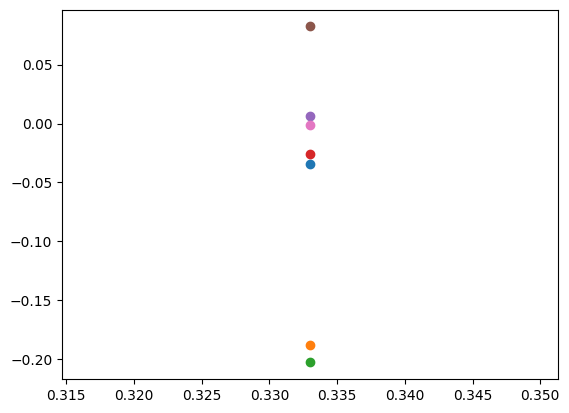

In [240]:
plt.plot(delay,  [exp.get_n_nearest_neighbors(1) for exp in batch_x.RamseyExperiments], 'o')